In [1]:
#importing dependencies and libraries 
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import seaborn as sns 

In [2]:
# Make connection to PostgreSQL
from config import password

protocol = 'postgresql'
username = 'postgres'
host = 'localhost'
port = 5432
database_name = 'telecom_customers'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [3]:
#read in csv 
telecoms_data = "./data/telecom_customer_churn.csv"
df = pd.read_csv(telecoms_data)

df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
#write raw data to sql database 
df.to_sql(name='raw_customer_info', con=engine, if_exists='append', index=False)

In [5]:
engine.table_names()

['raw_customer_info', 'algo_customer_info']

In [6]:
#check it has pushed to sql correctly 
pd.read_sql_query('select * from raw_customer_info', con=engine).head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,None,None
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,None,None
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


# EDA

In [7]:
#read in csv 
telecoms_data = "./data/telecom_customer_churn.csv"
eda_df = pd.read_csv(telecoms_data)

eda_df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [8]:
#Get the Summary Statistics
summary_df = eda_df.describe()
summary_df

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.


Text(0, 0.5, 'Count')

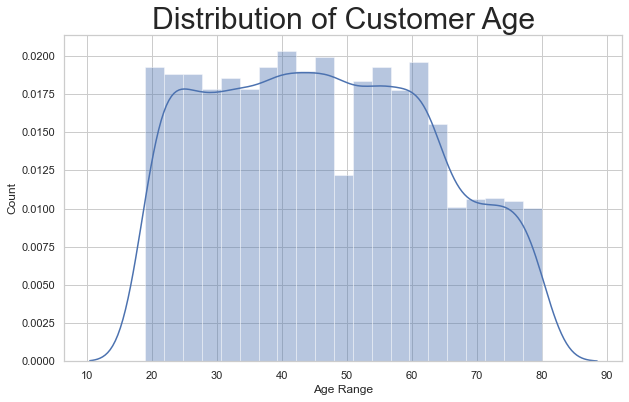

In [9]:
#Distribution of Age
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(eda_df['Age'])
plt.title('Distribution of Customer Age', fontsize = 30)
plt.xlabel('Age Range')
plt.ylabel('Count')

C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


Text(0, 0.5, 'Count')

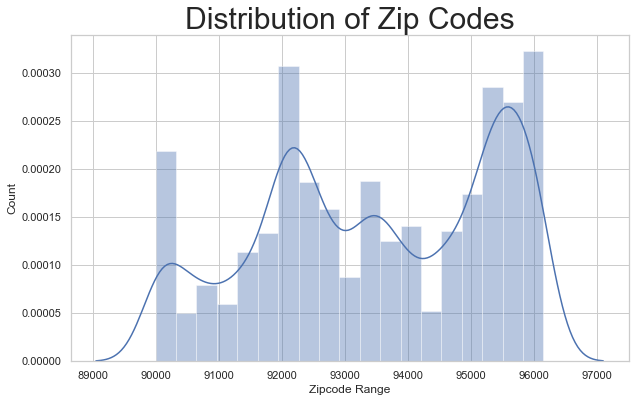

In [10]:
#Distribution of Zip Codes


plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(eda_df['Zip Code'])
plt.title('Distribution of Zip Codes', fontsize = 30)
plt.xlabel('Zipcode Range')
plt.ylabel('Count')

C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.


Text(0, 0.5, 'Count')

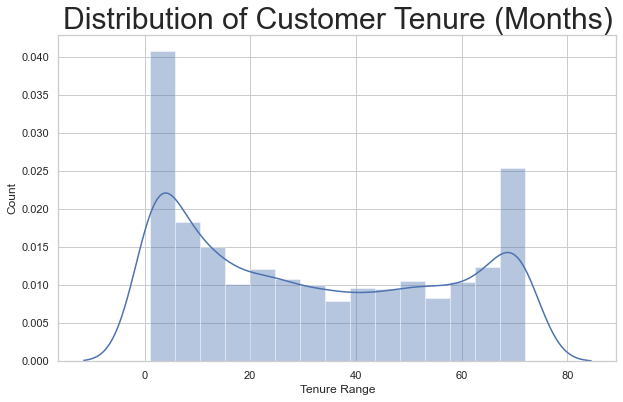

In [11]:
#Distribution of Tenure
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(eda_df['Tenure in Months'])
plt.title('Distribution of Customer Tenure (Months)', fontsize = 30)
plt.xlabel('Tenure Range')
plt.ylabel('Count')

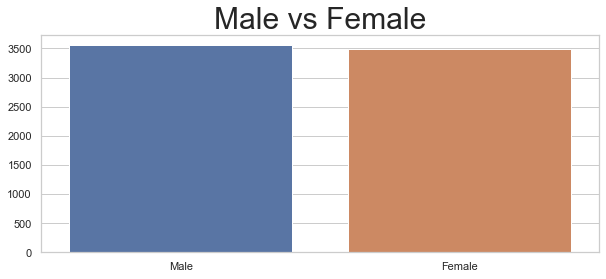

In [12]:
#Bar chart - male vs female 

genders = eda_df.Gender.value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.title('Male vs Female', fontsize = 30)
sns.barplot(x=genders.index, y=genders.values)
plt.show()

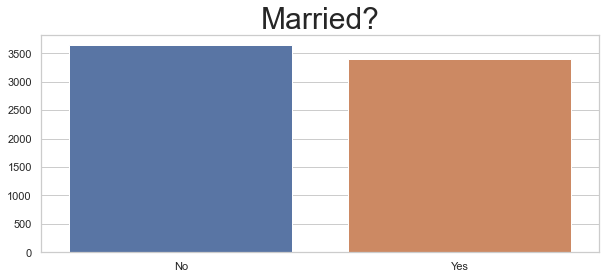

In [13]:
#Plot bar charts - Marital Status

married = eda_df.Married.value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.title('Married?', fontsize = 30)
sns.barplot(x=married.index, y=married.values)
plt.show()

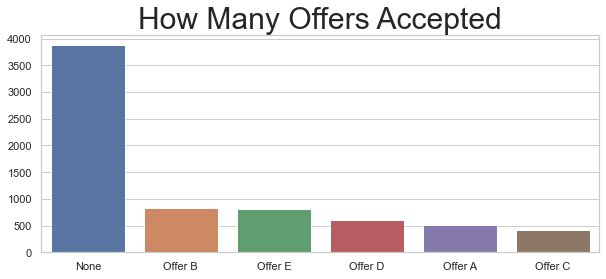

In [14]:
#Plot bar charts - Offers

offers = eda_df.Offer.value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.title('How Many Offers Accepted', fontsize = 30)
sns.barplot(x=offers.index, y=offers.values)
plt.show()

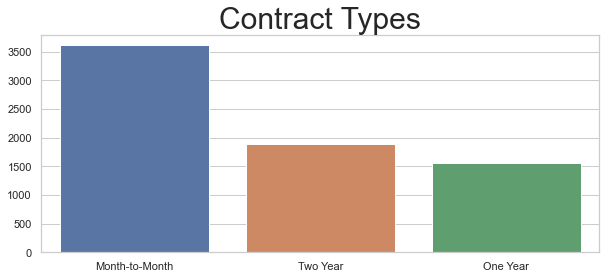

In [15]:
#Plot bar charts - contract types

contracts = eda_df.Contract.value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(10,4))
plt.title('Contract Types', fontsize = 30)
sns.barplot(x=contracts.index, y=contracts.values)
plt.show()

C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


Text(0, 0.5, 'Count')

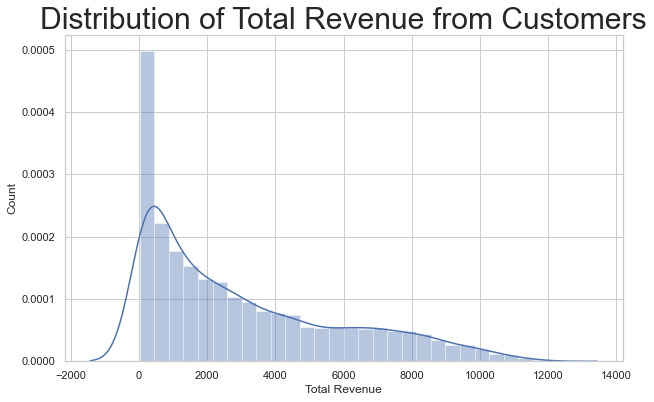

In [16]:
#Distribution of Total Revenue 

plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(eda_df['Total Revenue'])
plt.title('Distribution of Total Revenue from Customers', fontsize = 30)
plt.xlabel('Total Revenue')
plt.ylabel('Count')

# ETL

In [17]:
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


In [18]:
#drop any rows that are duplicates of other rows 
telecoms_df = df.drop_duplicates()

telecoms_df


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


In [19]:
telecoms_df = telecoms_df.dropna(how = 'all')

telecoms_df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN


In [20]:
telecoms_df.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

In [21]:
#dropping columns that are not necessary for the clustering 
telecoms_df = telecoms_df.drop(columns = ['Churn Category', 'Churn Reason', 'Customer ID','Latitude', 'Longitude', 'Offer', 
                                          'Avg Monthly Long Distance Charges', 'Multiple Lines','Avg Monthly GB Download',
                                          'Online Security', 'Online Backup', 'Device Protection Plan', 
                                          'Premium Tech Support', 'Unlimited Data', 'Paperless Billing', 'Payment Method',
                                          'Monthly Charge', 'Total Charges','Total Extra Data Charges', 
                                          'Total Long Distance Charges', 'City', 'Customer Status', 'Internet Type', 
                                          'Streaming TV', 'Streaming Movies', 'Streaming Music'])

telecoms_df

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Phone Service,Internet Service,Contract,Total Refunds,Total Revenue
0,Female,37,Yes,0,93225,2,9,Yes,Yes,One Year,0.00,974.81
1,Male,46,No,0,91206,0,9,Yes,Yes,Month-to-Month,38.33,610.28
2,Male,50,No,0,92627,0,4,Yes,Yes,Month-to-Month,0.00,415.45
3,Male,78,Yes,0,94553,1,13,Yes,Yes,Month-to-Month,0.00,1599.51
4,Female,75,Yes,0,93010,3,3,Yes,Yes,Month-to-Month,0.00,289.54
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,20,No,0,91941,0,13,Yes,Yes,One Year,0.00,1349.74
7039,Male,40,Yes,0,95367,1,22,Yes,Yes,Month-to-Month,0.00,2230.10
7040,Male,22,No,0,95432,0,2,Yes,Yes,Month-to-Month,0.00,129.99
7041,Male,21,Yes,0,92075,5,67,Yes,Yes,Two Year,0.00,4769.69


#### Changing categorical values (e.g. 'yes'/'no') to numeric values

In [22]:
telecoms_df['Gender'] = telecoms_df['Gender'].replace(to_replace=['Female', 'Male'], value=[0, 1])

#Female = 0, Male = 1

telecoms_df

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Phone Service,Internet Service,Contract,Total Refunds,Total Revenue
0,0,37,Yes,0,93225,2,9,Yes,Yes,One Year,0.00,974.81
1,1,46,No,0,91206,0,9,Yes,Yes,Month-to-Month,38.33,610.28
2,1,50,No,0,92627,0,4,Yes,Yes,Month-to-Month,0.00,415.45
3,1,78,Yes,0,94553,1,13,Yes,Yes,Month-to-Month,0.00,1599.51
4,0,75,Yes,0,93010,3,3,Yes,Yes,Month-to-Month,0.00,289.54
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,20,No,0,91941,0,13,Yes,Yes,One Year,0.00,1349.74
7039,1,40,Yes,0,95367,1,22,Yes,Yes,Month-to-Month,0.00,2230.10
7040,1,22,No,0,95432,0,2,Yes,Yes,Month-to-Month,0.00,129.99
7041,1,21,Yes,0,92075,5,67,Yes,Yes,Two Year,0.00,4769.69


In [23]:
telecoms_df['Married'] = telecoms_df['Married'].replace(to_replace=['No', 'Yes'], value=[0, 1])
telecoms_df['Phone Service'] = telecoms_df['Phone Service'].replace(to_replace=['No', 'Yes'], value=[0, 1])
telecoms_df['Internet Service'] = telecoms_df['Internet Service'].replace(to_replace=['No', 'Yes'], value=[0, 1])
telecoms_df['Contract'] = telecoms_df['Contract'].replace(to_replace=['Month-to-Month', 'One Year', 'Two Year'], value=[0, 1, 2])

# Female = 0, Male = 1
# No = 0, Yes = 1
# Month-to-month = 0, One Year = 1, Two Year = 2

telecoms_df

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Phone Service,Internet Service,Contract,Total Refunds,Total Revenue
0,0,37,1,0,93225,2,9,1,1,1,0.00,974.81
1,1,46,0,0,91206,0,9,1,1,0,38.33,610.28
2,1,50,0,0,92627,0,4,1,1,0,0.00,415.45
3,1,78,1,0,94553,1,13,1,1,0,0.00,1599.51
4,0,75,1,0,93010,3,3,1,1,0,0.00,289.54
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,20,0,0,91941,0,13,1,1,1,0.00,1349.74
7039,1,40,1,0,95367,1,22,1,1,0,0.00,2230.10
7040,1,22,0,0,95432,0,2,1,1,0,0.00,129.99
7041,1,21,1,0,92075,5,67,1,1,2,0.00,4769.69


In [24]:
#checking for any NaN values 
telecoms_df.isna().sum()

Gender                  0
Age                     0
Married                 0
Number of Dependents    0
Zip Code                0
Number of Referrals     0
Tenure in Months        0
Phone Service           0
Internet Service        0
Contract                0
Total Refunds           0
Total Revenue           0
dtype: int64

In [25]:
#the above data is what we will use for the algorithms to cluster - writing this data back to another table in our SQL database

telecoms_df.to_sql(name='algo_customer_info', con=engine, if_exists='append', index=False)

# Customer Segmentation With K-Means Clustering

## Using both PCA & t-SNE for Dimensionality Reduction

In [26]:
#Standarize the data with standard scaler
telecoms_df_scaled =StandardScaler().fit_transform(telecoms_df)
print(telecoms_df_scaled[0:5])

[[-1.00955867 -0.56777322  1.03453023 -0.4868349  -0.14061486  0.01603903
  -0.95299362  0.32743831  0.52592737  0.28902128 -0.24831297 -0.71887199]
 [ 0.99053183 -0.03043292 -0.96662231 -0.4868349  -1.22806568 -0.65040855
  -0.95299362  0.32743831  0.52592737 -0.88965671  4.60232501 -0.84610754]
 [ 0.99053183  0.20838499 -0.96662231 -0.4868349  -0.46270282 -0.65040855
  -1.15673995  0.32743831  0.52592737 -0.88965671 -0.24831297 -0.914111  ]
 [ 0.99053183  1.88011037  1.03453023 -0.4868349   0.5746574  -0.31718476
  -0.78999655  0.32743831  0.52592737 -0.88965671 -0.24831297 -0.5008267 ]
 [-1.00955867  1.70099694  1.03453023 -0.4868349  -0.25641572  0.34926281
  -1.19748922  0.32743831  0.52592737 -0.88965671 -0.24831297 -0.95805863]]


#### PCA dimensionality reduction

In [27]:
#Apply PCA to reduce dimensions
pca = PCA(n_components=0.9)

# Get two principal components for the iris data.
telecoms_df_pca = pca.fit_transform(telecoms_df_scaled)

In [28]:
# Transform PCA data to a DataFrame
telecoms_reduced = pd.DataFrame(
    data=telecoms_df_pca, columns=["principal component 1", "principal component 2", "principal component 3", "principal component 4", "principal component 5", "principal component 6", "principal component 7", "principal component 8", "principal component 9"]
)
telecoms_reduced.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9
0,-0.352968,0.490947,0.468665,-0.845036,-0.580600,0.105834,-0.506932,-0.426923,-0.751722
1,-1.737020,-0.611964,0.198748,-0.779807,3.931923,2.227387,1.340786,-1.296938,-0.091280
2,-2.110750,-0.356938,0.108116,0.022444,0.448710,-0.861800,0.697985,-0.196039,0.075036
3,-0.773957,-0.430839,0.886990,0.070635,1.311215,-1.806099,-0.760647,0.545982,-0.113958
4,-0.942410,0.093287,1.264041,-1.661672,0.475510,-0.931786,-1.284370,0.673195,-0.415244


#### TSNE - further reduces our dimensions and helps us visualise

In [29]:
# Initialize t-SNE model
tsne = TSNE(learning_rate=35)

In [30]:
# Reduce dimensions
tsne_features = tsne.fit_transform(telecoms_reduced)

C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [31]:
# Checking the dataset has 2 columns
tsne_features.shape

(7043, 2)

In [32]:
tsne_features.dtype

dtype('float32')

In [33]:
# Prepare to plot the dataset

# The first column of transformed features
telecoms_reduced['x'] = tsne_features[:,0]

# The second column of transformed features
telecoms_reduced['y'] = tsne_features[:,1]

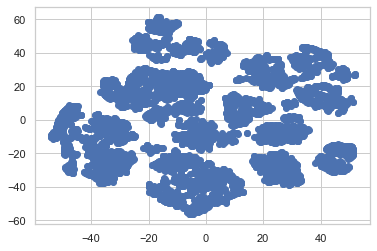

In [34]:
# Visualize to see if any clusters 
plt.scatter(telecoms_reduced['x'], telecoms_reduced['y'])
plt.show()

In [35]:
#Cluster analysis using k-means
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(tsne_features)
    inertia.append(km.inertia_)

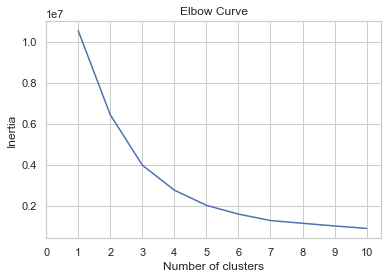

In [36]:
#To create an Elbow curve to see what value of n should be 
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [37]:
# Initializing model
model = KMeans(n_clusters=5, random_state=5)

In [38]:
# Fitting model
model.fit(telecoms_reduced)

KMeans(n_clusters=5, random_state=5)

In [39]:
# Predict clusters
predictions = model.predict(telecoms_reduced)

# Add the predicted class column to the dataframe
telecoms_reduced["class"] = model.labels_
telecoms_reduced.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,x,y,class
0,-0.352968,0.490947,0.468665,-0.845036,-0.580600,0.105834,-0.506932,-0.426923,-0.751722,-18.198919,-44.169029,1
1,-1.737020,-0.611964,0.198748,-0.779807,3.931923,2.227387,1.340786,-1.296938,-0.091280,-0.428864,-5.325726,1
2,-2.110750,-0.356938,0.108116,0.022444,0.448710,-0.861800,0.697985,-0.196039,0.075036,39.977699,15.422904,0
3,-0.773957,-0.430839,0.886990,0.070635,1.311215,-1.806099,-0.760647,0.545982,-0.113958,-6.005720,28.315088,2
4,-0.942410,0.093287,1.264041,-1.661672,0.475510,-0.931786,-1.284370,0.673195,-0.415244,-2.930748,-55.017765,1


In [40]:
print(model.labels_)

[1 1 0 ... 0 2 2]


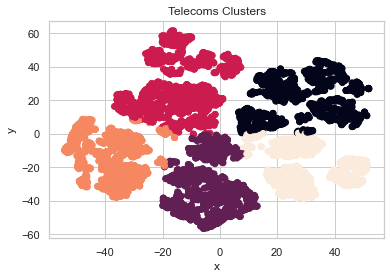

In [41]:
# Visualize the clusters
plt.scatter(telecoms_reduced['x'], telecoms_reduced['y'], c=telecoms_reduced['class'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Telecoms Clusters')
plt.show()

In [42]:
df["Category"] = telecoms_reduced["class"]
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Category
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,1
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,1
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,0
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,2
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,1


In [44]:
df.to_csv("./data/Categorized.csv")

## t-SNE Dimensionality Reduction Only

In [45]:
# Initialize t-SNE model
tsne = TSNE(learning_rate=35)

In [46]:
# Reduce dimensions
tsne_features = tsne.fit_transform(telecoms_df_scaled)

C:\Users\Spectre 13 X360\anaconda3\envs\PythonData\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [47]:
# The dataset has 2 columns
tsne_features.shape

(7043, 2)

In [48]:
# Prepare to plot the dataset
df2 = pd.DataFrame()
# The first column of transformed features
df2['x'] = tsne_features[:,0]

# The second column of transformed features
df2['y'] = tsne_features[:,1]

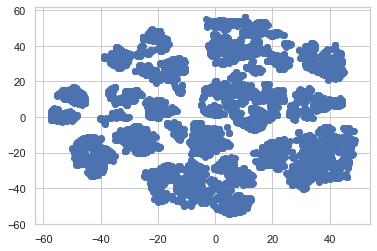

In [49]:
# Visualize to see if any clusters 
plt.scatter(df2['x'], df2['y'])
plt.show()

In [50]:
#Cluster analysis using k-means
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(tsne_features)
    inertia.append(km.inertia_)

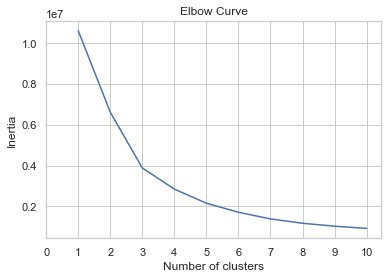

In [51]:
#To create an Elbow curve to see what value of n should be 
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [52]:
# Initializing model
model = KMeans(n_clusters=5, random_state=42)

In [53]:
# Fitting model
model.fit(df2)

KMeans(n_clusters=5, random_state=42)

In [54]:
# Predict clusters
predictions = model.predict(df2)

# Add the predicted class column to the dataframe
df2["class"] = model.labels_
df2.head()

,x,y,class
0,34.412693,-19.474777,0
1,-4.396837,-7.989902,3
2,6.482266,12.145728,2
3,-23.950031,-33.120647,3
4,41.313229,-12.475933,0


In [55]:
print(model.labels_)

[0 3 2 ... 2 3 4]


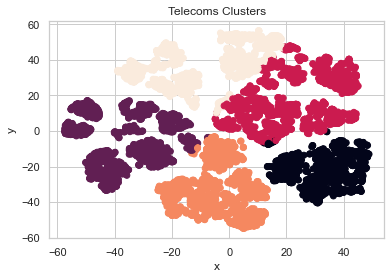

In [56]:
# Visualize the clusters
plt.scatter(df2['x'], df2['y'], c=df2['class'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Telecoms Clusters')
plt.show()

In [57]:
df["Category"] = df2["class"]
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Category
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,0
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,3
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,2
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,3
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,0


In [58]:
df.to_csv("./data/Categorized_t-SNE.csv")

## PCA Dimensionality Reduction

In [59]:
#Applying PCA to reduce dimensions
pca = PCA(n_components=2)

# Get two principal components for the telecoms data.
telecoms_df_pca = pca.fit_transform(telecoms_df_scaled)

In [60]:
# Transform PCA data to a DataFrame
telecoms_reduced = pd.DataFrame(
    data=telecoms_df_pca, columns=["principal component 1", "principal component 2"]
)
telecoms_reduced.head()

,principal component 1,principal component 2
0,-0.352968,0.490947
1,-1.737020,-0.611964
2,-2.110750,-0.356938
3,-0.773957,-0.430839
4,-0.942410,0.093287


In [61]:
#To analyze the cluster using k-means
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(tsne_features)
    inertia.append(km.inertia_)

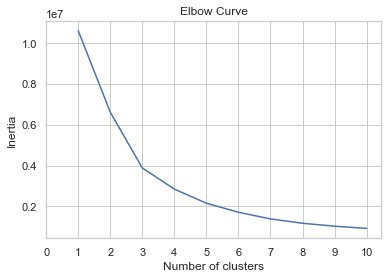

In [62]:
#Elbow curve to see what value of N should be 
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [63]:
# To Initialize the model
model = KMeans(n_clusters=5, random_state=5)

In [64]:
# Fitting model
model.fit(telecoms_reduced)

KMeans(n_clusters=5, random_state=5)

In [65]:
# Predict clusters
predictions = model.predict(telecoms_reduced)

# Add the predicted class column to the dataframe
telecoms_reduced["class"] = model.labels_
telecoms_reduced.head()

,principal component 1,principal component 2,class
0,-0.352968,0.490947,1
1,-1.737020,-0.611964,2
2,-2.110750,-0.356938,2
3,-0.773957,-0.430839,2
4,-0.942410,0.093287,1


In [66]:
print(model.labels_)

[1 2 2 ... 2 0 4]


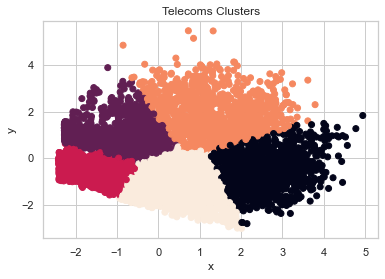

In [67]:
# Visualizing the clusters
plt.scatter(telecoms_reduced['principal component 1'], telecoms_reduced['principal component 2'], c=telecoms_reduced['class'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Telecoms Clusters')
plt.show()

In [68]:
df["Category"] = telecoms_reduced["class"]
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Category
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,1
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,2
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,2
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,2
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,1


In [69]:
df.to_csv("./data/Categorized_pca.csv")

## Hierarchical Clustering

In [70]:
#Confirm existing dataset
telecoms_df.head()

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Phone Service,Internet Service,Contract,Total Refunds,Total Revenue
0,0,37,1,0,93225,2,9,1,1,1,0.00,974.81
1,1,46,0,0,91206,0,9,1,1,0,38.33,610.28
2,1,50,0,0,92627,0,4,1,1,0,0.00,415.45
3,1,78,1,0,94553,1,13,1,1,0,0.00,1599.51
4,0,75,1,0,93010,3,3,1,1,0,0.00,289.54


In [71]:
#Normalize the dataframe
normalized = normalize(telecoms_df)

In [72]:
mergings = linkage(normalized, method="ward")

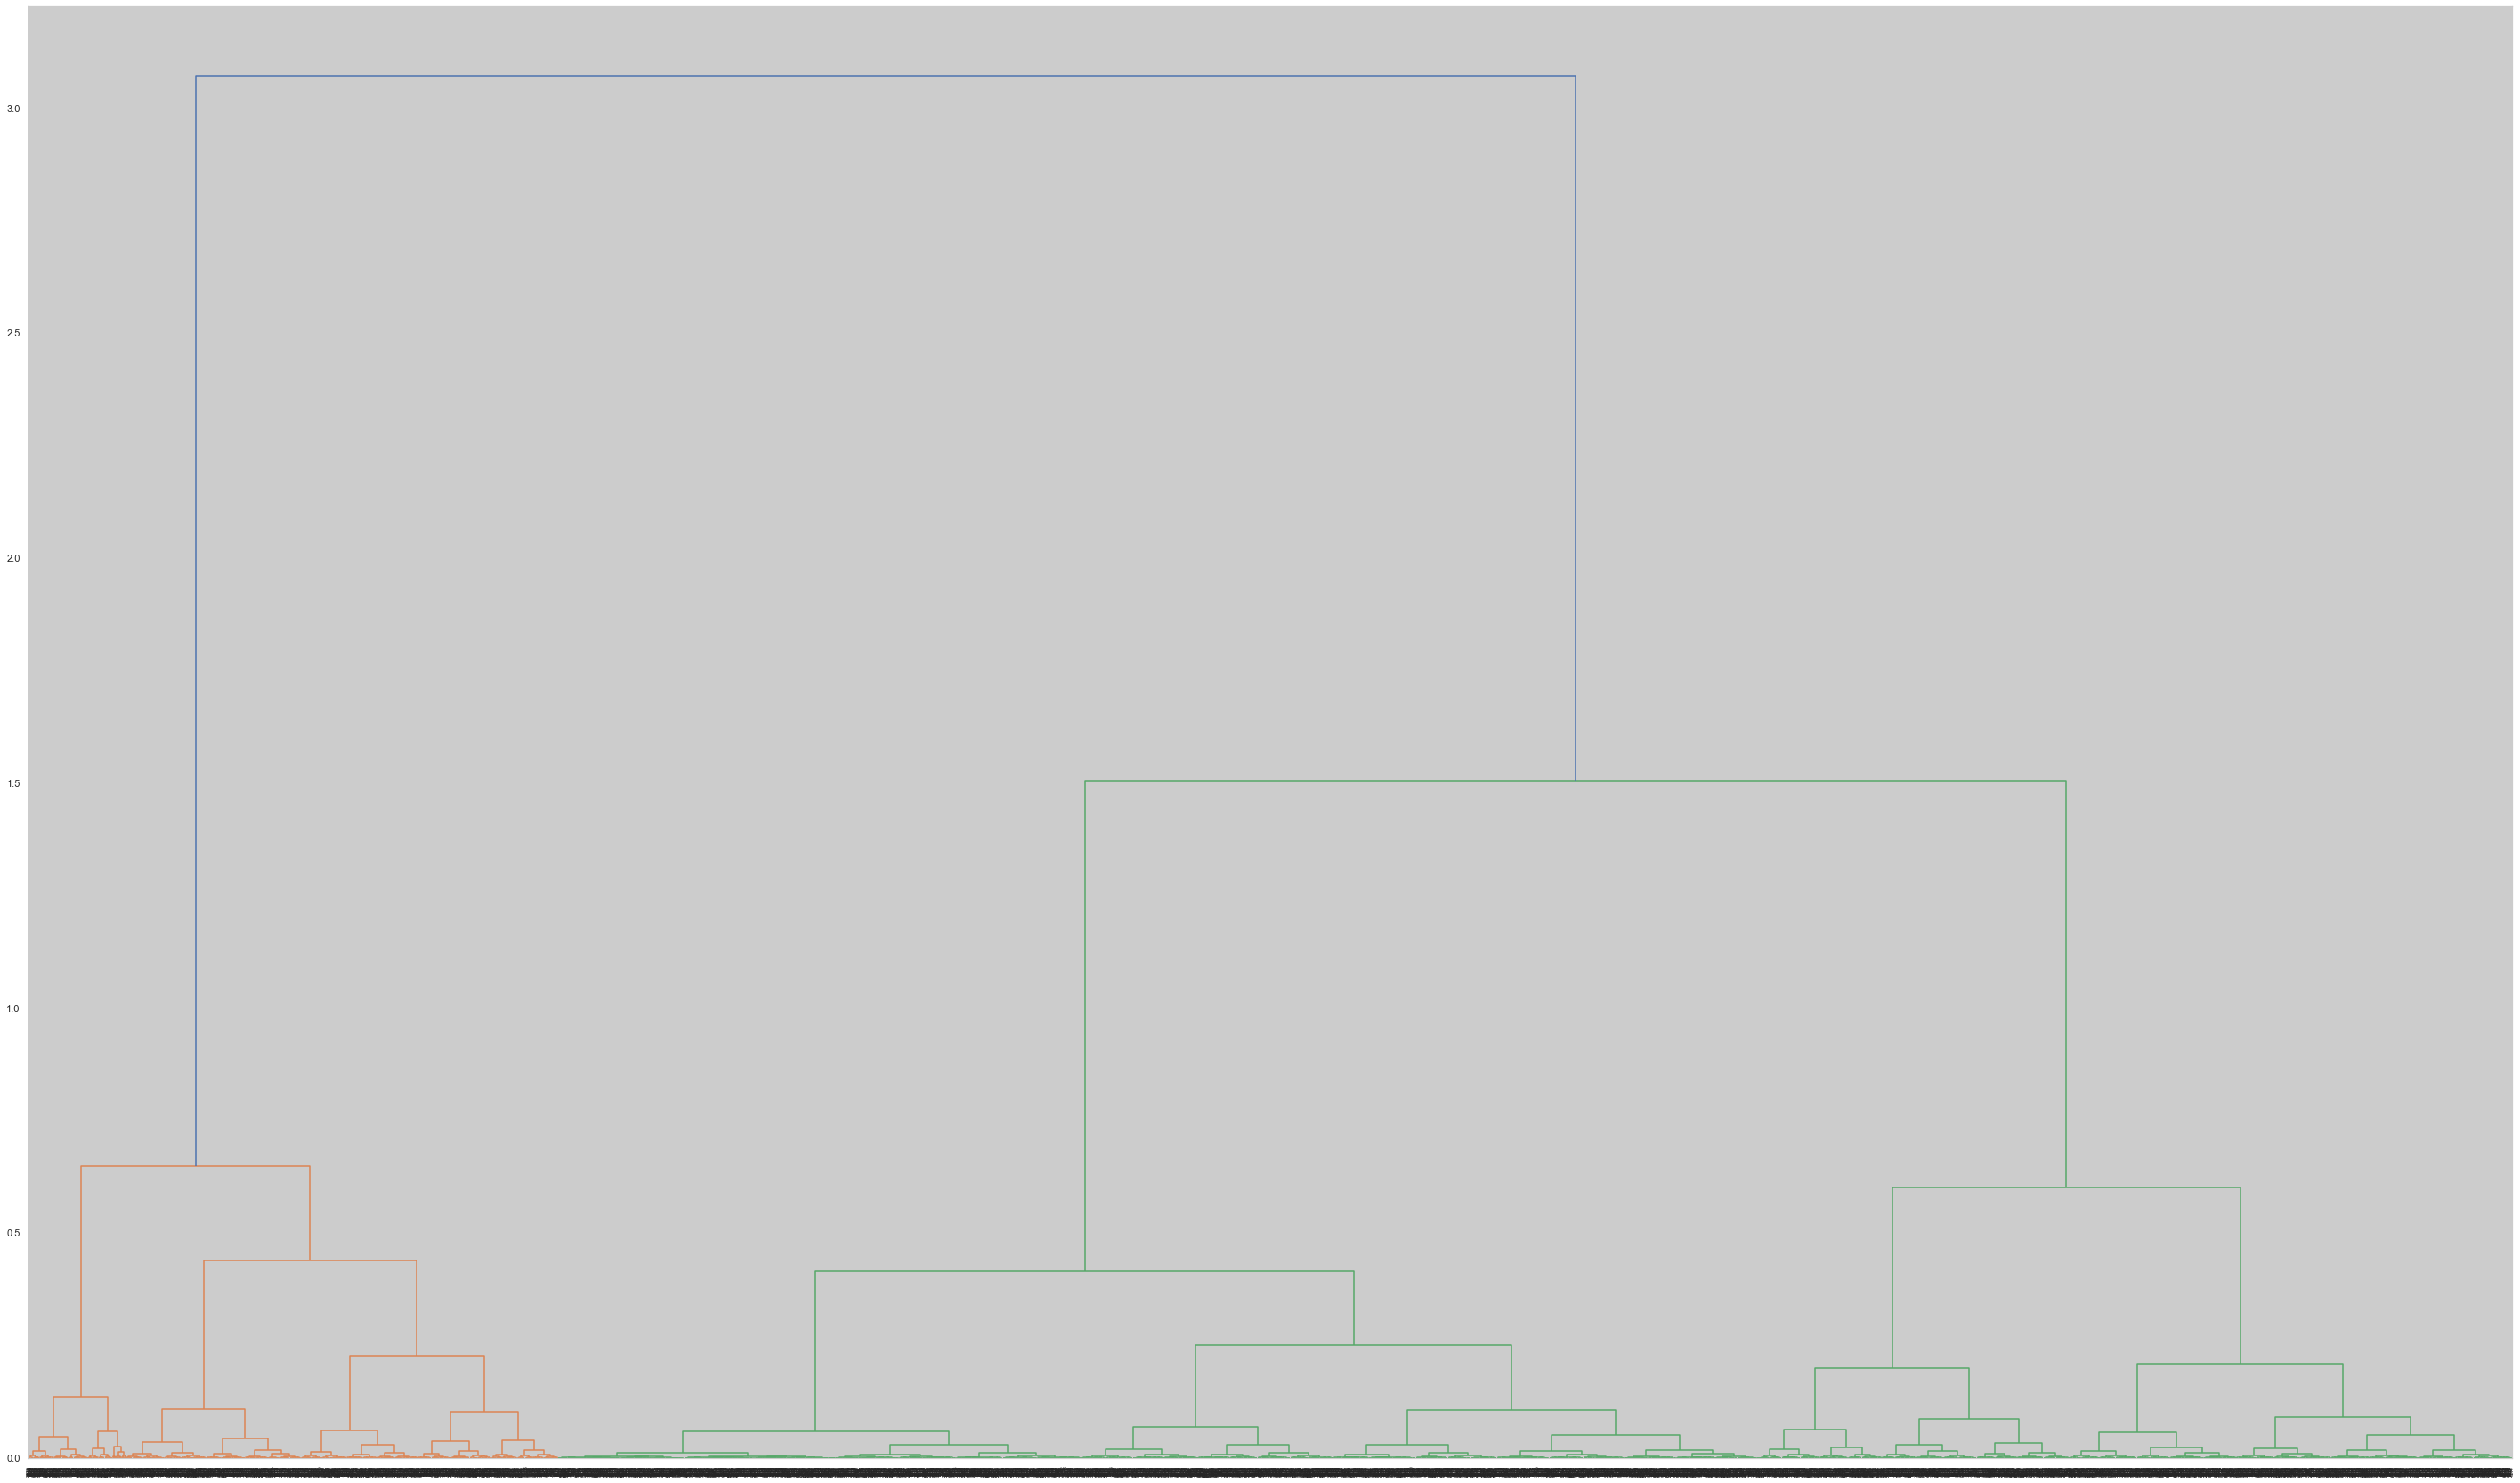

In [73]:
plt.figure(figsize=(50,30))

dendrogram(mergings,
          leaf_rotation=90,
          leaf_font_size=5)

plt.show()

In [74]:
df2 = pd.DataFrame(normalized)
df2.columns = telecoms_df.columns

In [75]:
cluster = AgglomerativeClustering(
    n_clusters=2,
    affinity="euclidean",
    linkage="ward"
)
labels = cluster.fit_predict(df2)

In [76]:
labels[:5]

array([0, 0, 0, 0, 0], dtype=int64)